In [432]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm

Define Functions

In [433]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    d = d.apply(pd.to_numeric, errors='ignore')
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [434]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var))
    d = pd.concat(d).reset_index()
    return d

In [435]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [436]:
def calc_dNdlogDp(data, bins):
    #Calculating dN/dlogDp for OPCs; requires dlogDp to be calculated for bins
    dNdlogDp = []
    for binN in bins.index[:-1]:
        dNdlogDp.append(data[f'bin{binN}']/bins.loc[binN, 'dlogDp'])
    dNdlogDp = pd.concat(dNdlogDp, axis = 1)
    dNdlogDp.columns = [f'{i}_norm' for i in dNdlogDp.columns]
        #Norm = /dlogDp
    return dNdlogDp

In [437]:
bins = pd.read_csv('./data/DASH_Bins_2023.csv').set_index('BinNum')

In [438]:
bins.loc[[(bins['Dp_nm'] - 600).abs().idxmin()], 'dlogDp']

BinNum
56    1.683947
Name: dlogDp, dtype: float64

Read OPC Data

In [439]:
def process(path, f_name):
    min_counts = 2.5
    dopc = add_bin_sum(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path))
    hopc = add_bin_sum(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path))
    dash = glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path)
    sems = glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path)
    merged = pd.merge_asof(dash, sems, on='dt')
    merged = pd.merge_asof(merged, dopc, on='dt').drop(columns=['index_x'])
    merged = pd.merge_asof(merged, hopc, on='dt')
    merged_diff = merged[['dt', 'UpSt_Dia', 'HM_RH']].diff()
    merged[['dt.diff', 'UpSt_Dia.diff', 'HM_RH.diff']] = merged_diff
    col_w_bin = [c for c in merged.columns if 'bin' in c and 'sum' not in c]
    col_w_DO_bin = [c for c in merged.columns if 'bin' in c and 'x' in c and 'sum' not in c]
    col_w_HO_bin = [c for c in merged.columns if 'bin' in c and 'y' in c and 'sum' not in c]

    new_group = True
    start_i = []
    end_i = []
    delay = False
    for i in range(0,len(merged)):
        row = merged.iloc[i]
        if delay == False:
            if new_group:
                start_i.append(i)
                new_group = False
            if abs(row['UpSt_Dia.diff']) > 0:
                print('UpSt_Dia.diff')
                end_i.append(i)
                new_group = True
                dt_switch = row['dt']+timedelta(seconds=16)
                delay = True
            elif abs(row['HM_RH.diff']) > 5:
                print('HM_RH.diff')
                end_i.append(i)
                new_group = True
        else:
            if row['dt'] > dt_switch:
                delay = False

        if i == len(merged)-1:
            if len(start_i) > len(end_i):
                end_i.append(i)
    for i in range(0, len(start_i)):
        if i < len(start_i)-1:
            print(start_i[i]-end_i[i])

    col = ['Samp_Num', 'Start_Date_Time_UTC', 'Mid_Date_Time_UTC', 'Stop_Date_Time_UTC', 'Samp_Time_s', 'data_points', 'UpSt_Dia', 'UpSt_Dia_Sdev', 'HM_RH_Av', 'HM_RH_Sdev', 'HO_RH_Av', 'HO_RH_Sdev', 'HO_below_cnts']
    comb_bins = []
    dopc_labels = []
    hopc_labels = []
    for i in range(1,73):
        if i < 10:
            dopc_labels.append('DO_Bin0'+str(i))
            hopc_labels.append('HO_Bin0'+str(i))
        else:
            dopc_labels.append('DO_Bin'+str(i))
            hopc_labels.append('HO_Bin'+str(i))
        
        if i < 10:
            col.append('DO_Bin0'+str(i))
            comb_bins.append('DO_Bin0'+str(i))
        else:
            col.append('DO_Bin'+str(i))
            comb_bins.append('DO_Bin'+str(i))



    for i in range(1,73):
        if i < 10:
            col.append('HO_Bin0'+str(i))
            comb_bins.append('HO_Bin0'+str(i))
        else:
            col.append('HO_Bin'+str(i))
            comb_bins.append('HO_Bin'+str(i))
    output = pd.DataFrame(columns = col)
    output = pd.DataFrame(columns = col)
    out_acc = 0
    data_points = 0
    for i in tqdm(range(0,len(start_i))):
        subset = merged.iloc[start_i[i]:end_i[i]+1].reset_index()
        DO_n_sum = 0
        HO_n_sum = 0
        dt_start = subset.loc[0,'dt']
        s = 0
        for j in range(0,len(subset)):
            DO_n_sum = subset.loc[s:j+1, col_w_DO_bin].sum().max()
            HO_n_sum = subset.loc[s:j+1, col_w_HO_bin].sum().max()
            if subset.loc[j, 'dt.diff'] > timedelta(seconds=2):
                break
            if subset.loc[j, 'dt'] - dt_start > timedelta(minutes=10):
                break
            if DO_n_sum > min_counts / float(bins.loc[[(bins['Dp_nm'] - subset.loc[j, 'UpSt_Dia']).abs().idxmin()], 'dlogDp']):
                output.loc[out_acc, 'Start_Date_Time_UTC'] = subset.loc[s, 'dt']
                output.loc[out_acc, 'Stop_Date_Time_UTC'] = subset.loc[j, 'dt']
                output.loc[out_acc, 'Mid_Date_Time_UTC'] = subset.loc[s, 'dt']+(subset.loc[j, 'dt']-subset.loc[s, 'dt'])/2
                output.loc[out_acc, 'Samp_Time_s'] = (subset.loc[j, 'dt']-subset.loc[s, 'dt']+timedelta(seconds=1)).total_seconds()
                
                output.loc[out_acc, 'data_points'] = subset.loc[s:j+1, 'UpSt_Dia'].count()
                data_points += output.loc[out_acc, 'data_points']

                output.loc[out_acc, 'UpSt_Dia'] = subset.loc[s:j+1, 'UpSt_Dia'].mean()
                output.loc[out_acc, 'HM_RH_Av'] = subset.loc[s:j+1, 'HM_RH'].mean()
                output.loc[out_acc, 'HO_RH_Av'] = subset.loc[s:j+1, 'HO_RH'].mean()

                output.loc[out_acc, 'UpSt_Dia_Sdev'] = subset.loc[s:j+1, 'UpSt_Dia'].std()
                output.loc[out_acc, 'HM_RH_Sdev'] = subset.loc[s:j+1, 'HM_RH'].std()
                output.loc[out_acc, 'HO_RH_Sdev'] = subset.loc[s:j+1, 'HO_RH'].std()

                output.loc[out_acc, comb_bins] = list(subset.loc[s:j+1, col_w_bin].sum())
                if HO_n_sum > min_counts / float(bins.loc[[(bins['Dp_nm'] - subset.loc[j, 'UpSt_Dia']).abs().idxmin()], 'dlogDp']):
                    output.loc[out_acc, 'HO_below_cnts'] = 0
                else:
                    output.loc[out_acc, 'HO_below_cnts'] = 1
                s = j
                dt_start = subset.loc[s,'dt']
                HO_n_sum = 0
                DO_n_sum = 0
                out_acc += 1

    output = output[output['HM_RH_Sdev']<5]
    output = output[output['UpSt_Dia_Sdev']==0]
    output = output.drop(columns=['UpSt_Dia_Sdev'])
    
    #output = output[output[dopc_labels].astype('float').idxmax(axis=1) != 'DO_Bin01']
    #output = output[output[hopc_labels].astype('float').idxmax(axis=1) != 'HO_Bin01']

    output['Samp_Num'] = output.reset_index().index+1
    output.to_csv('./processed_opc/DASH_SAMP_PARAM_'+f_name+'.csv', index=None)
    print('Fraction of data used =', str(round(data_points/len(dopc), 2)))
    print('Data with usable GF =', str(len(output[output['HO_below_cnts']==0])/len(output)))

    s_t = sorted(list(output['Start_Date_Time_UTC'])+list(output['Stop_Date_Time_UTC']))
    fig, axes = plt.subplots(2, figsize=(5, 2.5), sharex='all')

    ax=axes[0]

    output['Time_Diff'] = output['Mid_Date_Time_UTC'].diff().dt.total_seconds() / 60

    # Identify the indices where the time difference is greater than 5 minutes
    gap_indices = output.index[output['Time_Diff'] > 5].tolist()

    old_i = 0
    output_GF = output[output['HO_below_cnts']==0]
    c = ['black', 'red']
    for i in gap_indices:
        ax.plot(output.loc[old_i:i-1,'Mid_Date_Time_UTC'], output.loc[old_i:i-1,'Samp_Time_s'], c='black')
        #ax.scatter(output_GF.loc[old_i:i-1,'Mid_Date_Time_UTC'], output_GF.loc[old_i:i-1,'Samp_Time_s'], c='lime', s=1, zorder=1000)
        ax.set_ylabel('Samp\nDuration [s]\n', rotation=0, labelpad=40, loc='bottom')
        old_i = i

    ax=axes[1]
    ax.scatter(dopc['dt'], ['Raw']*len(dopc), s=.1)
    ax.scatter(s_t, ['Retrieved']*len(s_t), s=.1)
    ax.set_ylim(-1,2)
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_xlabel('Hour [UTC]')
    fig.tight_layout()
    fig.savefig('./figures/process-'+f_name+'.png')
    return output

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_99588/3185608673.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_99588/3185608673.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)


-37
-7
-9
-2785
-52
-36
-10666
-32
-32
-31
-32
-38
-3585
-351
-210
-1196
-31
-32
-32
-32
-32
-31
-32
-32
-31
-32
-32
-40
-869
-32
-32
-31
-32
-32
-32
-32
-32
-32
-4
-1040
-83
-458
-75
-652
-22
-6878
-170


100%|██████████| 48/48 [00:52<00:00,  1.10s/it]


Fraction of data used = 0.86
Data with usable GF = 0.8655262018189692


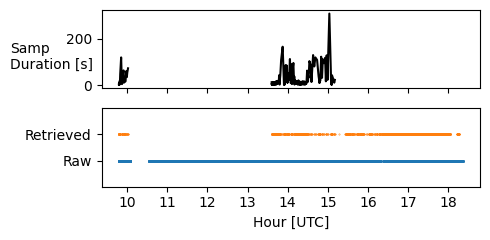

In [440]:
output = process('./data/DASH-flight-2024_05_30/', 'RESAMP_240530')

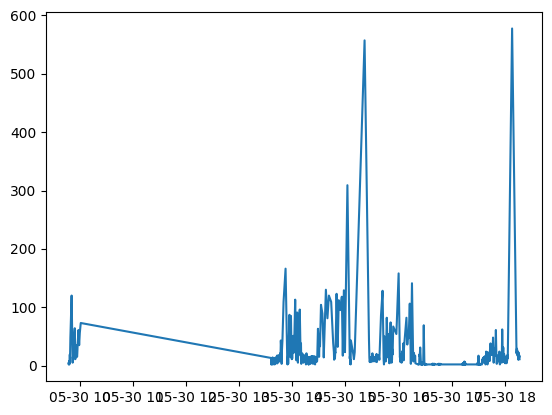

In [441]:
plt.plot(output['Mid_Date_Time_UTC'], output['Samp_Time_s'])

In [442]:
output['Samp_Time_s'].iloc[-2]

17.09632

In [443]:
output[np.isnan(output['Samp_Time_s'].astype('float'))]

,Samp_Num,Start_Date_Time_UTC,Mid_Date_Time_UTC,Stop_Date_Time_UTC,Samp_Time_s,data_points,UpSt_Dia,HM_RH_Av,HM_RH_Sdev,HO_RH_Av,...,HO_Bin64,HO_Bin65,HO_Bin66,HO_Bin67,HO_Bin68,HO_Bin69,HO_Bin70,HO_Bin71,HO_Bin72,Time_Diff


In [444]:
output[np.isfinite(output['Samp_Time_s'])]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
path = './data/DASH-flight-2024_05_30/'
dopc = add_bin_sum(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path))
hopc = add_bin_sum(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path))
dash = glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path)
sems = glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path)
merged = pd.merge_asof(dash, sems, on='dt')
merged = pd.merge_asof(merged, dopc, on='dt').drop(columns=['index_x'])
merged = pd.merge_asof(merged, hopc, on='dt')
merged_diff = merged[['dt', 'UpSt_Dia', 'HM_RH']].diff()
merged[['dt.diff', 'UpSt_Dia.diff', 'HM_RH.diff']] = merged_diff

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_99588/3185608673.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_99588/3185608673.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)


In [ ]:
dopc

,index,YY/MM/DD,HR:MN:SC,samp_intrvl,total_conc,sample_flw,sheath_flw,sheath_temp,samp_press,lasr_brt,...,bin67,bin68,bin69,bin70,bin71,bin72,sd_save,sd_install,dt,bin_sum
0,0,24/05/30,09:47:17,1,0.0,-0.011,0.67,21.5,937,2628,...,0,0,0,0,0,0,1,1,2024-05-30 09:47:17,0
1,1,24/05/30,09:47:18,1,0.0,-0.011,0.70,21.5,929,2628,...,0,0,0,0,0,0,1,1,2024-05-30 09:47:18,0
2,2,24/05/30,09:47:19,1,0.0,-0.006,0.73,21.5,919,2627,...,0,0,0,0,0,0,1,1,2024-05-30 09:47:19,0
3,3,24/05/30,09:47:20,1,0.0,-0.001,0.75,21.5,909,2628,...,0,0,0,0,0,0,1,1,2024-05-30 09:47:20,0
4,4,24/05/30,09:47:21,1,0.0,0.009,0.77,21.5,900,2627,...,0,0,0,0,0,0,1,1,2024-05-30 09:47:21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29870,7104,24/05/30,18:21:44,1,0.0,-0.018,0.24,21.6,1049,2635,...,0,0,0,0,0,0,1,1,2024-05-30 18:21:44,0
29871,7105,24/05/30,18:21:45,1,0.0,-0.018,0.19,21.5,1042,2637,...,0,0,0,0,0,0,1,1,2024-05-30 18:21:45,0
29872,7106,24/05/30,18:21:47,1,0.0,-0.018,0.30,23.9,1078,2634,...,0,0,0,0,0,0,1,1,2024-05-30 18:21:47,0
29873,7107,24/05/30,18:21:48,1,0.0,-0.018,0.31,24.1,1076,2634,...,0,0,0,0,0,0,1,1,2024-05-30 18:21:48,0


In [ ]:
output

,Samp_Num,Start_Date_Time_UTC,Mid_Date_Time_UTC,Stop_Date_Time_UTC,Samp_Time_s,data_points,UpSt_Dia,HM_RH_Av,HM_RH_Sdev,HO_RH_Av,...,HO_Bin64,HO_Bin65,HO_Bin66,HO_Bin67,HO_Bin68,HO_Bin69,HO_Bin70,HO_Bin71,HO_Bin72,Time_Diff
1,1,2024-05-30 09:47:30.301440,2024-05-30 09:47:31.800480,2024-05-30 09:47:33.299520,3.99808,5,200.0,18.08,0.130384,81.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2,2024-05-30 09:47:33.299520,2024-05-30 09:47:34.798560,2024-05-30 09:47:36.297600,3.99808,5,200.0,18.22,0.248998,65.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049968
3,3,2024-05-30 09:47:36.297600,2024-05-30 09:47:37.800960,2024-05-30 09:47:39.304320,4.00672,5,200.0,18.54,0.194936,53.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050040
4,4,2024-05-30 09:47:39.304320,2024-05-30 09:47:40.302240,2024-05-30 09:47:41.300160,2.99584,4,200.0,18.825,0.262996,47.775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041688
5,5,2024-05-30 09:47:41.300160,2024-05-30 09:47:41.801280,2024-05-30 09:47:42.302400,2.00224,3,200.0,19.066667,0.23094,46.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617,4614,2024-05-30 18:15:19.200960,2024-05-30 18:15:29.698560,2024-05-30 18:15:40.196160,21.9952,23,200.0,87.069565,1.320618,81.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249984
4618,4615,2024-05-30 18:15:40.196160,2024-05-30 18:15:50.698080,2024-05-30 18:16:01.200000,22.00384,23,200.0,86.652174,1.541212,79.652174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349992
4619,4616,2024-05-30 18:16:01.200000,2024-05-30 18:16:07.701600,2024-05-30 18:16:14.203200,14.0032,15,200.0,86.353333,1.451042,78.646667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283392
4620,4617,2024-05-30 18:16:14.203200,2024-05-30 18:16:22.251360,2024-05-30 18:16:30.299520,17.09632,18,200.0,83.911111,0.994034,78.738889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242496


<AxesSubplot: >

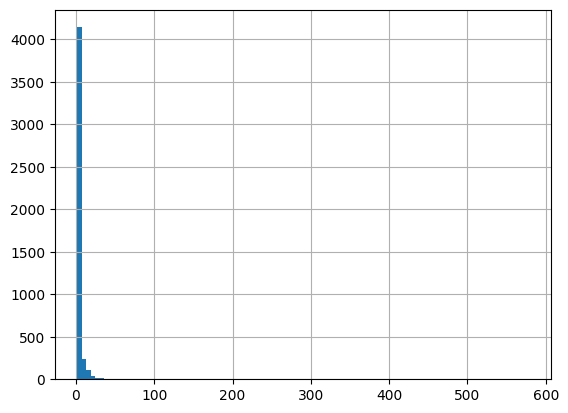

In [ ]:
output['Samp_Time_s'].hist(bins=100)

<AxesSubplot: xlabel='Start_Date_Time_UTC', ylabel='Samp_Time_s'>

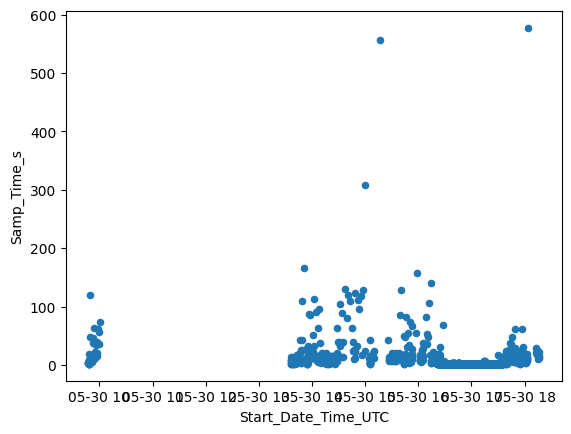

In [ ]:
output.plot.scatter(x='Start_Date_Time_UTC', y='Samp_Time_s')